In [22]:
# importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

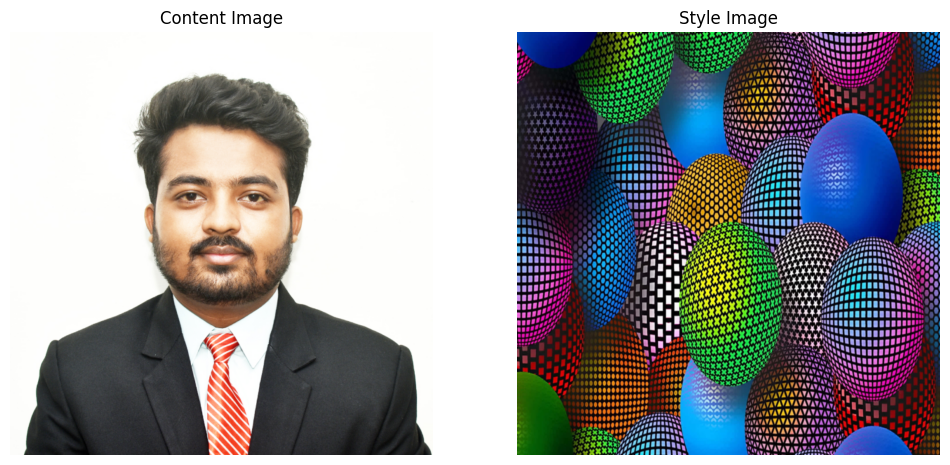

In [24]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Desired size of the output image
imsize = 720  # Set the size to 720x720

# Define the image loader
loader = transforms.Compose([
    transforms.Resize(imsize),  # Scale the imported image to 720x720
    transforms.ToTensor()])  # Transform it into a torch tensor

# Create an unloader to convert the tensor to an image
unloader = transforms.ToPILImage()

# Define the image loading function
def image_loader(image_name, target_size=None):
    image = Image.open(image_name)

    if target_size is not None:
        image = transforms.Resize(target_size)(image)

    # Fake batch dimension required to fit the network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the style and content images
content_img_path = '/content/Harsh 2.jpg'
style_img_path = '/content/3d-pictures.jpg'

content_img = image_loader(content_img_path)
style_img = image_loader(style_img_path, target_size=content_img.shape[-2:])

# Display the style and content images
plt.ion()

# Example: Display content and style images
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
axarr[0].imshow(unloader(content_img.squeeze(0)))
axarr[0].set_title('Content Image')
axarr[0].axis('off')

axarr[1].imshow(unloader(style_img.squeeze(0)))
axarr[1].set_title('Style Image')
axarr[1].axis('off')

plt.show()


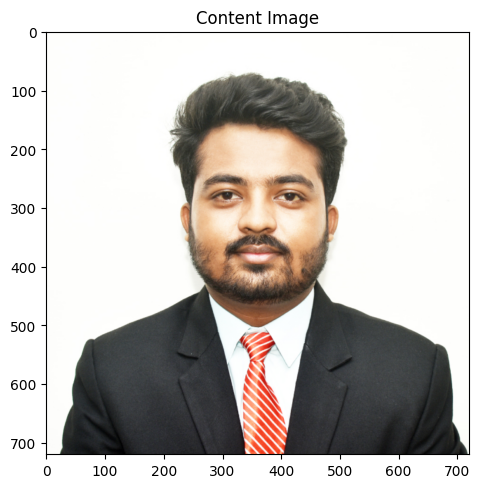

<ipython-input-25-f50f6977efa1>:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


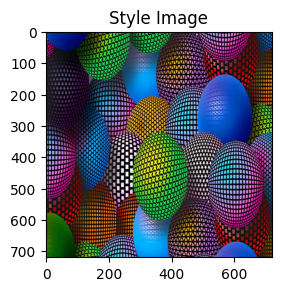

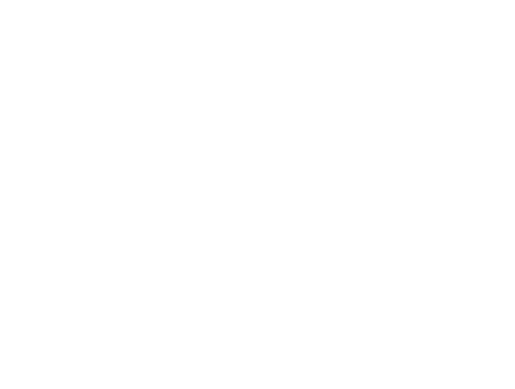

In [25]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # Clone the tensor to prevent changes
    image = image.squeeze(0)      # Remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit to update the plots

# Display the style and content images
plt.figure(figsize=(12, 6))

# Display the content image
plt.subplot(1, 2, 1)
imshow(content_img, title='Content Image')
plt.axis('off')

# Display the style image
plt.subplot(1, 2, 2)
imshow(style_img, title='Style Image')
plt.axis('off')

plt.show()


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Desired size of the output image
imsize = 720  # Set the size to 720x720

# Define the image loader
loader = transforms.Compose([
    transforms.Resize(imsize),  # Scale the imported image to 720x720
    transforms.ToTensor()])  # Transform it into a torch tensor

# Create an unloader to convert the tensor to an image
unloader = transforms.ToPILImage()

# Display the style and content images
plt.ion()

# ...

# Define the ContentLoss class
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Define the Gram matrix calculation
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1), b=number of feature maps, (c,d)=dimensions of a feature map (N=c*d)
    features = input.view(a * b, c * d)  # Resize F_XL into F^hat_XL
    G = torch.mm(features, features.t())  # Compute the Gram product
    # Normalize the values of the Gram matrix by dividing by the number of elements in each feature map
    return G.div(a * b * c * d)

# Define the StyleLoss class
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [27]:
# Load the pre-trained VGG19 model
cnn = models.vgg19_bn(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

# Desired size of the output image
imsize = 720  # Set the size to 720x720

# Define the image loader
loader = transforms.Compose([
    transforms.Resize(imsize),  # Scale the imported image to 720x720
    transforms.ToTensor()])  # Transform it into a torch tensor

# Create an unloader to convert the tensor to an image
unloader = transforms.ToPILImage()

# Display the style and content images
plt.ion()

# ...

# Define the Normalization module
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Define the desired depth layers to compute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,
                               content_layers=content_layers_default, style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


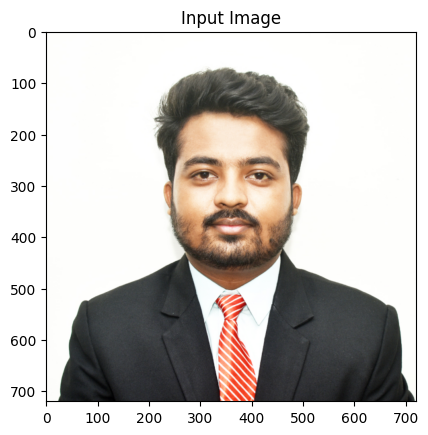

In [29]:
input_img = content_img.clone()

# If you want to use white noise as the initial input, you can use the following line:
# input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

In [30]:
import torch.optim as optim

# ...

# Define the get_input_optimizer function
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Define the run_style_transfer function
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img,
                      num_steps=300, style_weight=100000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]

    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


Building the style transfer model..
Optimizing..


<ipython-input-28-0d14f7390736>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-28-0d14f7390736>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 17.559729 Content Loss: 0.000610

run [100]:
Style Loss : 17.337450 Content Loss: 0.002292

run [150]:
Style Loss : 17.104588 Content Loss: 0.004737

run [200]:
Style Loss : 16.856859 Content Loss: 0.007702

run [250]:
Style Loss : 16.593384 Content Loss: 0.011023

run [300]:
Style Loss : 16.113657 Content Loss: 0.501325



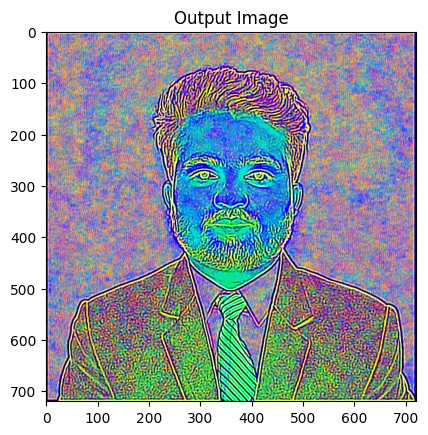

In [31]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()
